  0%|          | 0/3 [00:00<?, ?it/s]

the type of scan is: Brain 1.25 mm SOFT
The actual shape of the scan is: (144, 512, 512)


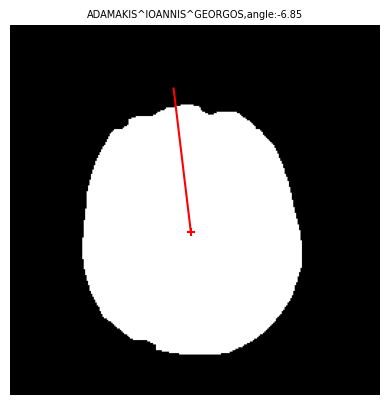

 33%|███▎      | 1/3 [00:29<00:58, 29.21s/it]

the initial angle is:  -6.852316845195276
patient's name:ADAMAKIS^IOANNIS^GEORGOS,patient's sex:M,patients'age:38,Glasgow Coma Scale:15
----------------------------------------------------------------------------------------------------
the type of scan is: Brain 1.25 mm SOFT
The actual shape of the scan is: (132, 512, 512)


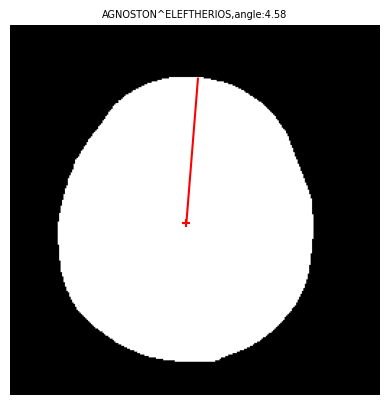

 67%|██████▋   | 2/3 [00:56<00:28, 28.15s/it]

the initial angle is:  4.582503649386638
patient's name:AGNOSTON^ELEFTHERIOS,patient's sex:F,patients'age:53,Glasgow Coma Scale:15
----------------------------------------------------------------------------------------------------
the type of scan is: Brain 1.25 mm SOFT
The actual shape of the scan is: (152, 512, 512)


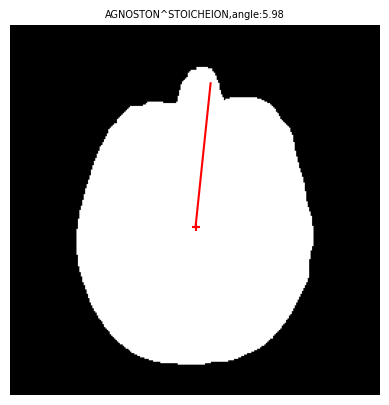

100%|██████████| 3/3 [01:27<00:00, 29.32s/it]

the initial angle is:  5.984342406051013
patient's name:AGNOSTON^STOICHEION,patient's sex:F,patients'age:NA,Glasgow Coma Scale:15
----------------------------------------------------------------------------------------------------


(3,)

In [1]:
import pydicom as dcm
import os
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
from segment_brain import segment
from tqdm import tqdm
import re
from CT_DATASET_module import *

PATH_WITH_ALL_SCANS = r'C:\Users\user1\Desktop\WIDE_RANGE' 
PATH_WITH_ALL_SCANS = r'C:\Users\user1\Desktop\NORMAL' 
desired_volume_dims_after_resampling = (120,256,256)
THRESHOLD = 20
all_patients =CT_DATASET(PATH_WITH_ALL_SCANS,desired_volume_dims_after_resampling)

patients = []
for patient in tqdm(os.listdir(PATH_WITH_ALL_SCANS)[:3]):  
# for patient in tqdm(os.listdir(PATH_WITH_ALL_SCANS)):    
        # for folder in os.listdir(os.path.join(PATH_WITH_ALL_SCANS,patient)):
            patients.append(all_patients.process_scan(os.path.join(PATH_WITH_ALL_SCANS,patient),patient))

patients = np.array(patients)
patients.shape

In [2]:
from My_model import MultipleInputsModel

In [3]:
X = np.array([patients[i]['volume']  for i in range(len(patients)) ])
X =np.transpose(X,(0,2,3,1))
print(X.shape)
y = np.array([np.random.randint(0, 2) for _ in range(X.shape[0])])[...,np.newaxis]
print(y.shape)

(3, 256, 256, 120)
(3, 1)


In [4]:
from sklearn.preprocessing import LabelEncoder

labels_sex = np.array([patients[i]['sex']  for i in range(len(patients)) ])
le = LabelEncoder()
le.fit(labels_sex)
labels_sex = le.transform(labels_sex)
labels_sex

array([1, 0, 0])

In [6]:
from sklearn.preprocessing import LabelEncoder

labels_age = np.array([patients[i]['age']  for i in range(len(patients)) ])
labels_age_categ = []
for age in labels_age:
    if age=='NA':
        labels_age_categ.append('NA')
    elif int(age)<30:
        labels_age_categ.append('Adult')
    elif int(age)>=30 and int(age)<60:
        labels_age_categ.append('Middle')
    else:
        labels_age_categ.append('Old')

labels_age_categ =np.array(labels_age_categ)

le = LabelEncoder()
le.fit(labels_age_categ)
labels_age = le.transform(labels_age_categ)
labels_age


array([0, 0, 1])

In [7]:
from sklearn.model_selection import train_test_split
X_train,  X_test,  y_train, y_test,   labels_sex_train, labels_sex_test,  labels_age_train, labels_age_test = train_test_split( X, y, labels_sex,labels_age,train_size=0.6)

In [8]:
model =MultipleInputsModel(input_shape=(256,256,120),sex_label_shape=(1,),age_label_shape=(1,))

# Train the model
history = model.fit (x=([X_train, labels_sex_train, labels_age_train]),y=y_train,
                     validation_data=(([X_test,labels_sex_test,labels_age_test] ),y_test),
                     epochs=5)




Epoch 1/5


1/1 [==============================] - 6s 6s/step - loss: 13.7609 - accuracy: 0.0000e+00 - val_loss: 3023.1401 - val_accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 6459.4307 - val_accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 10717.4385 - val_accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 15690.7285 - val_accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 21232.4844 - val_accuracy: 0.0000e+00


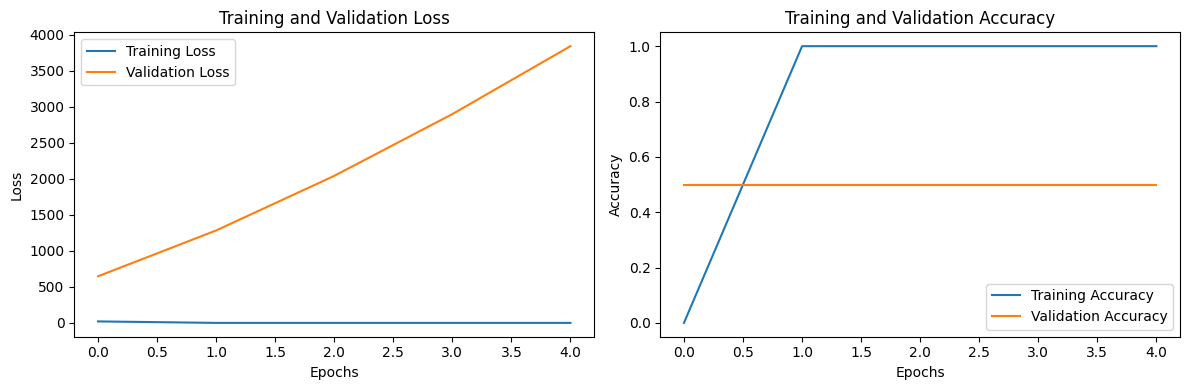

In [35]:
import matplotlib.pyplot as plt


# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:


import plotly.graph_objects as go
import plotly.express as px



# Create a Plotly figure for loss
fig_loss = go.Figure()

fig_loss.add_trace(go.Scatter(x=history.epoch,
                             y=history.history['loss'],
                             mode='lines',
                             name='Training Loss',
                             line=dict(color='blue')))
fig_loss.add_trace(go.Scatter(x=history.epoch,
                             y=history.history['val_loss'],
                             mode='lines',
                             name='Validation Loss',
                             line=dict(color='orange')))

fig_loss.update_layout(title='Training and Validation Loss',
                      xaxis_title='Epochs',
                      yaxis_title='Loss',
                      template='plotly_dark')

# Create a Plotly figure for accuracy
fig_accuracy = go.Figure()

fig_accuracy.add_trace(go.Scatter(x=history.epoch,
                                 y=history.history['accuracy'],
                                 mode='lines',
                                 name='Training Accuracy',
                                 line=dict(color='green')))
fig_accuracy.add_trace(go.Scatter(x=history.epoch,
                                 y=history.history['val_accuracy'],
                                 mode='lines',
                                 name='Validation Accuracy',
                                 line=dict(color='red')))

fig_accuracy.update_layout(title='Training and Validation Accuracy',
                          xaxis_title='Epochs',
                          yaxis_title='Accuracy',
                          template='plotly_dark')

# Show the figures
fig_loss.show()
fig_accuracy.show()



In [37]:
model.predict([X_test,labels_sex_test,labels_age_test] )

1/1 [==============================] - 1s 1s/step


array([[0.],
       [0.]], dtype=float32)

In [38]:
model.predict([np.expand_dims(X_test[0],axis=0) ,   np.array([labels_sex_test[0]]),  np.array([labels_sex_test[0]])   ] )

1/1 [==============================] - 0s 464ms/step


array([[0.]], dtype=float32)

In [ ]:
#δεν παιζει τα labels

import numpy as np
from tensorflow.keras.preprocessing import image

# Assuming you have a single image file path, sex label, and age label
image_path = 'PATH_TO_IMAGE'
sex_label = 'Male'  # or 'Female'
age_label = 'Middle'  # or any appropriate age label

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Assuming you normalized your images during training

# Encode sex label
sex_encoded = le.transform([sex_label])

# Encode age label
age_encoded = np.array([age_label])

# Make the prediction
prediction = model.predict([np.expand_dims(X_test[0],axis=0), sex_encoded, age_encoded])

# Convert the prediction to a binary class (0 or 1)
binary_prediction = 1 if prediction > 0.5 else 0

print("Predicted Probability:", prediction)
print("Predicted Class:", binary_prediction)